# Classification Models
***

In [1]:
%load_ext autoreload
%autoreload 2
from functions import *

In [2]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import itertools
from sklearn import metrics

from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV, cross_val_score)

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
                              
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
RandomForestRegressor)

from sklearn.metrics import (classification_report, confusion_matrix, 
                             plot_confusion_matrix, precision_score, 
                             accuracy_score, recall_score, f1_score, roc_curve, 
                             auc)

from scipy.special import logit

plt.style.use('seaborn')

import shap
shap.initjs()

from alibi.explainers import KernelShap
from scipy.special import logit

from sklearn.feature_extraction.text import TfidfVectorizer

***
# Preprocessing data
***

In [3]:
# Load dataset and ceate pd dataframes
raw_df = pd.read_csv('../DATA/data.csv')

In [4]:
raw_df.describe().round(2)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00
mean,0.53,1976.79,0.50,0.54,230948.31,0.48,0.08,0.17,5.20,0.21,-11.47,0.71,31.43,0.10,116.86
std,0.26,25.92,0.38,0.18,126118.41,0.27,0.28,0.31,3.52,0.17,5.70,0.46,21.83,0.16,30.71
min,0.00,1921.00,0.00,0.00,5108.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00
25%,0.32,1956.00,0.10,0.42,169827.00,0.26,0.00,0.00,2.00,0.10,-14.62,0.00,11.00,0.03,93.42
50%,0.54,1977.00,0.52,0.55,207467.00,0.47,0.00,0.00,5.00,0.14,-10.58,1.00,33.00,0.04,114.73
75%,0.75,1999.00,0.89,0.67,262400.00,0.70,0.00,0.10,8.00,0.26,-7.18,1.00,48.00,0.08,135.54
max,1.00,2020.00,1.00,0.99,5403500.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,243.51


In [5]:
raw_df.shape

(170653, 19)

## Popularity Distribution
Using classification models, I want to predict the popularity of a song given the features of tha data set. This data set includes a column for song popularity, which is ranges from 0-100, with 100 being the most popular. I will plot the popularity distribution of these scores. 

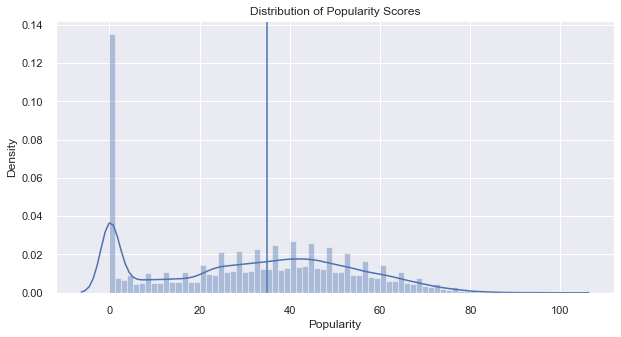

In [6]:
fig = plt.figure(figsize=(10,5))
sns.set(style="darkgrid") 
sns.distplot(raw_df['popularity'], label="Popularity", bins='auto')
plt.xlabel("Popularity")
plt.ylabel("Density")
plt.title("Distribution of Popularity Scores")
plt.axvline(35)
plt.show()

## Create caterogrical (binary) target
In order to create a variable to be the target of this classification analysis, I decided to use a popularity of 35 as a threshold value. In this step, I will create a new binary column named "popular". This column will have a threshold of 35 popularity. If the song popularity is greater than or equal to 35, then it will be classified a popular song (1). Otherwise, the song is not popular (0). I will build other models that have different threshold values and compare model performance.

In [7]:
raw_df['popular'] = (raw_df['popularity'] >= 35).astype('int')
raw_df['popular'].value_counts(1)

0    0.516838
1    0.483162
Name: popular, dtype: float64

In [8]:
raw_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,popular
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,0
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,0
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,0
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,0
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,0


In [9]:
# Save raw dataframe with 'popular column' as csv file and store in DATA folder
raw_df.to_csv('../DATA/raw_df.csv') 

## Make a new dataframe with necessary information

In [10]:
df = raw_df[['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
             'energy', 'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'tempo', 'key', 'popular']]

In [11]:
df.head()

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,popular
0,0.0594,1921,0.982,0.279,831667,0.211,0.878000,0.665,-20.096,0.0366,80.954,10,0
1,0.9630,1921,0.732,0.819,180533,0.341,0.000000,0.160,-12.441,0.4150,60.936,7,0
2,0.0394,1921,0.961,0.328,500062,0.166,0.913000,0.101,-14.850,0.0339,110.339,3,0
3,0.1650,1921,0.967,0.275,210000,0.309,0.000028,0.381,-9.316,0.0354,100.109,5,0
4,0.2530,1921,0.957,0.418,166693,0.193,0.000002,0.229,-10.096,0.0380,101.665,3,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   danceability      170653 non-null  float64
 4   duration_ms       170653 non-null  int64  
 5   energy            170653 non-null  float64
 6   instrumentalness  170653 non-null  float64
 7   liveness          170653 non-null  float64
 8   loudness          170653 non-null  float64
 9   speechiness       170653 non-null  float64
 10  tempo             170653 non-null  float64
 11  key               170653 non-null  int64  
 12  popular           170653 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 16.9 MB


# Logistic Regression Models
***

## LR Model 1: Baseline model

### Define X and y

In [13]:
X = df[['valence', 'acousticness', 'danceability', 'duration_ms',
             'energy', 'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'tempo', 'key']]

y = df['popular']

### Train Test Split

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

### Standardize train and test sets

In [15]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns,
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns,
                      index=X_test.index)

In [16]:
X_train.describe()

,valence,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key
count,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05
mean,-5.010312e-16,1.989135e-16,-2.233406e-16,3.375368e-17,-2.270601e-17,-6.162267e-17,-8.449523e-17,-1.749862e-16,-1.221350e-17,-1.965819e-16,6.872871e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.009135e+00,-1.334439e+00,-3.051065e+00,-1.804732e+00,-1.803641e+00,-5.324759e-01,-1.177821e+00,-8.526212e+00,-6.058416e-01,-3.805010e+00,-1.477230e+00
25%,-8.050031e-01,-1.063191e+00,-6.941392e-01,-4.906357e-01,-8.510256e-01,-5.324759e-01,-6.125898e-01,-5.538219e-01,-3.895165e-01,-7.642656e-01,-9.083984e-01
50%,4.206759e-02,3.243965e-02,5.553347e-02,-1.896643e-01,-4.410426e-02,-5.317792e-01,-3.997699e-01,1.555142e-01,-3.269124e-01,-7.101690e-02,-5.515034e-02
75%,8.321605e-01,1.040313e+00,7.427334e-01,2.531205e-01,8.263248e-01,-2.064863e-01,3.153506e-01,7.520733e-01,-1.378603e-01,6.063688e-01,7.980977e-01
max,1.789388e+00,1.314221e+00,2.560122e+00,3.238798e+01,1.932106e+00,2.663501e+00,4.543143e+00,2.690890e+00,5.406634e+00,4.126716e+00,1.651346e+00


### Instantiate classifier and fit

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

### Predict

In [18]:
pred = logreg.predict(X_test)

### Summary Plot Mean absolute error of each feature

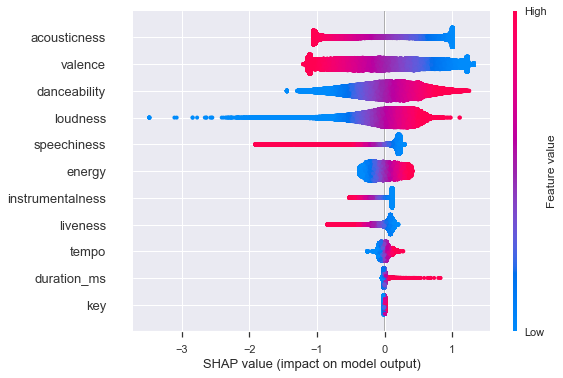

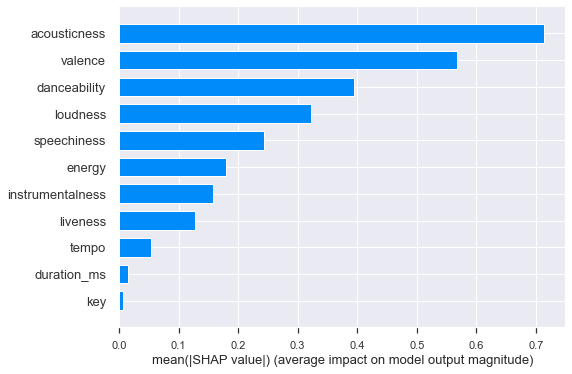

In [19]:
plot_shap(logreg, X_train)

X-axis: does it help the model more towards the positive outcome (popular) or negative outcome (not popular).

The newer songs are often more popular 

### Model Coefficients
"Generally, positive coefficients make the event more likely and negative coefficients make the event less likely. An estimated coefficient near 0 implies that the effect of the predictor is small."

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”

In [20]:
find_coeffs(logreg, X_train, X).style.background_gradient(cmap='coolwarm')

,coef
danceability,0.480870
loudness,0.409793
energy,0.209477
tempo,0.066586
duration_ms,0.025412
key,0.007105
liveness,-0.184288
instrumentalness,-0.197915
speechiness,-0.368268
valence,-0.665554


### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.76      0.76      0.76     22069
     Popular       0.75      0.75      0.75     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664



----------------------------------------------------------
Training Accuracy Score: 75.75%
Testing Accuracy Score: 75.67%
Accuracy: 75.67%


----------------------------------------------------------


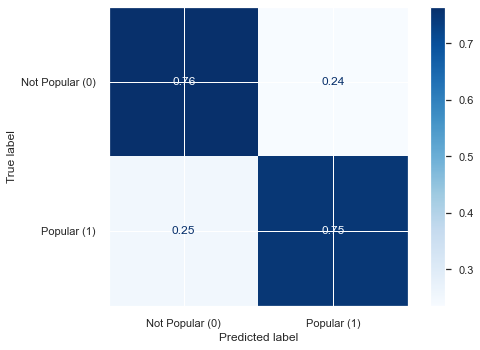

In [21]:
model_performance(logreg, X_train, X_test, y_train, y_test, pred)

Notes:
* Model has accuracy of 84% 
* Issues predicting popular songs. Too many false negatives and false positives

### ROC Curve and AUC
"ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s."

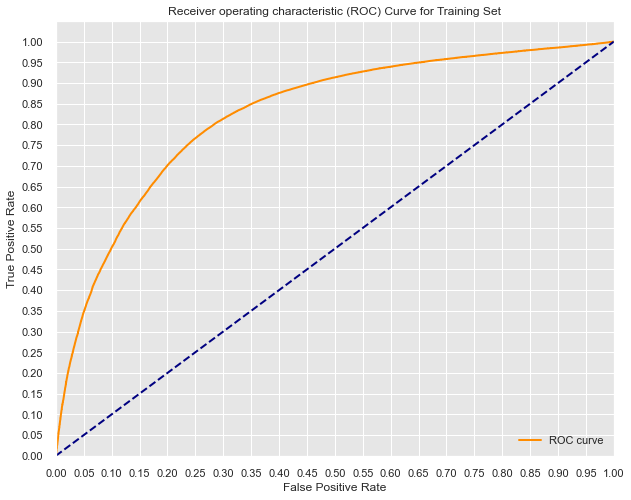

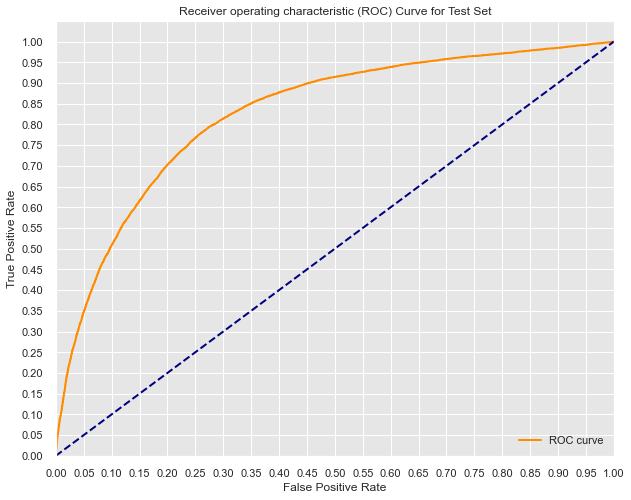

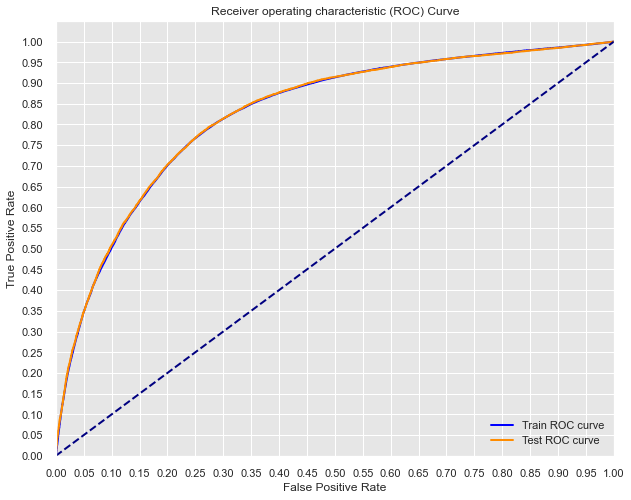

Train AUC: 0.8248905721724435
Test AUC: 0.8257122447769725


In [22]:
roc_auc(logreg, X_train, X_test, y_train, y_test)

AUC is looking pretty good but could be better. Also the ROC curve could be more perpendicular

***
## LR Model 2: LogisticRegressionCV

### Instantiate classifier and fit model

In [23]:
logregcv = LogisticRegressionCV()
logregcv.fit(X_train, y_train)

LogisticRegressionCV()

### Predict

In [24]:
pred = logregcv.predict(X_test)

### Summary Plot and Mean absolute error 

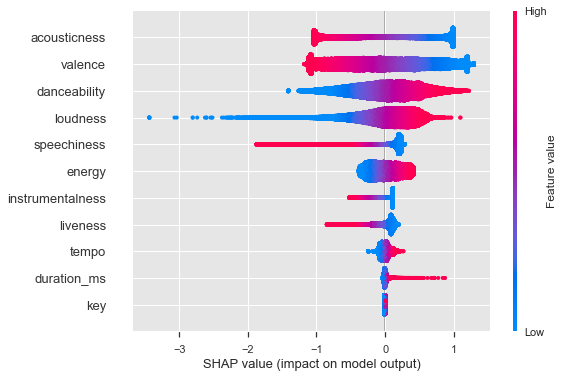

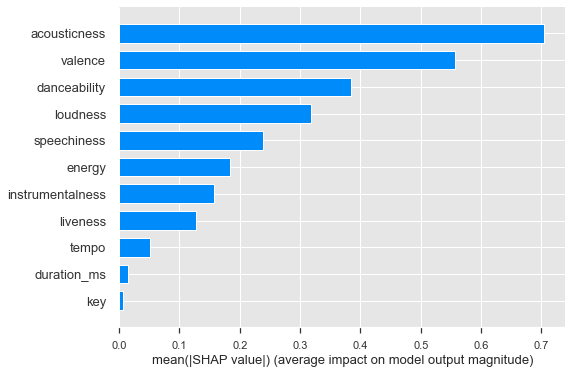

In [25]:
plot_shap(logregcv, X_train)

### Model  coefficients

In [26]:
find_coeffs(logregcv, X_train, X).style.background_gradient(cmap='coolwarm')

,coef
danceability,0.469579
loudness,0.404460
energy,0.214315
tempo,0.064652
duration_ms,0.026815
key,0.006954
liveness,-0.184105
instrumentalness,-0.197915
speechiness,-0.360529
valence,-0.651481


### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.77      0.76      0.76     22069
     Popular       0.75      0.75      0.75     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664



----------------------------------------------------------
Training Accuracy Score: 75.75%
Testing Accuracy Score: 75.7%
Accuracy: 75.7%


----------------------------------------------------------


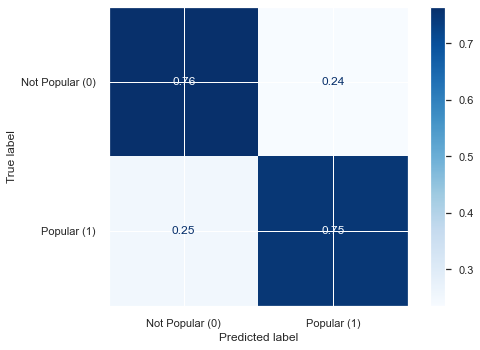

In [27]:
model_performance(logregcv, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

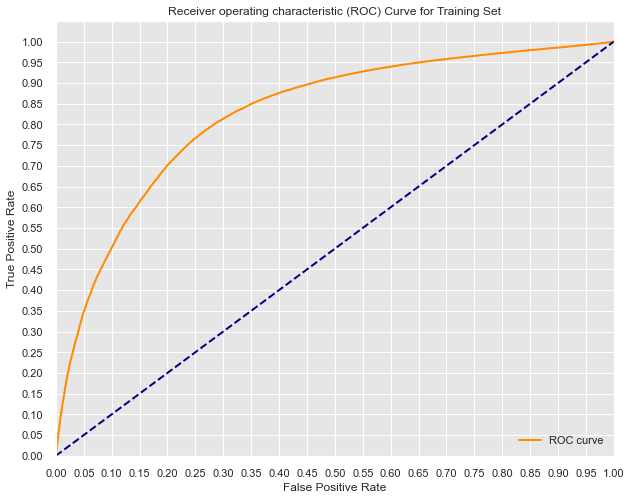

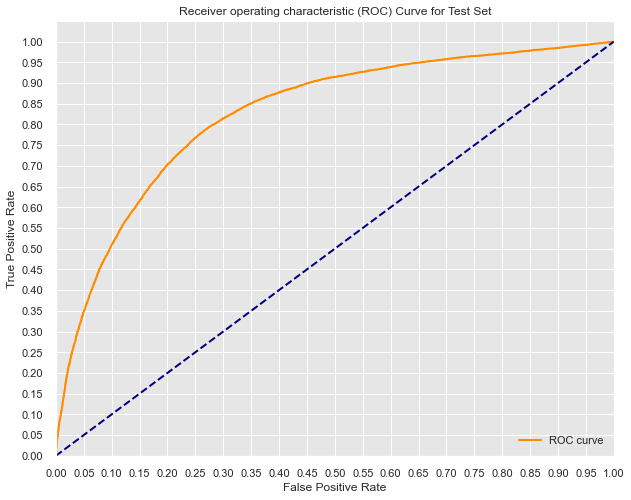

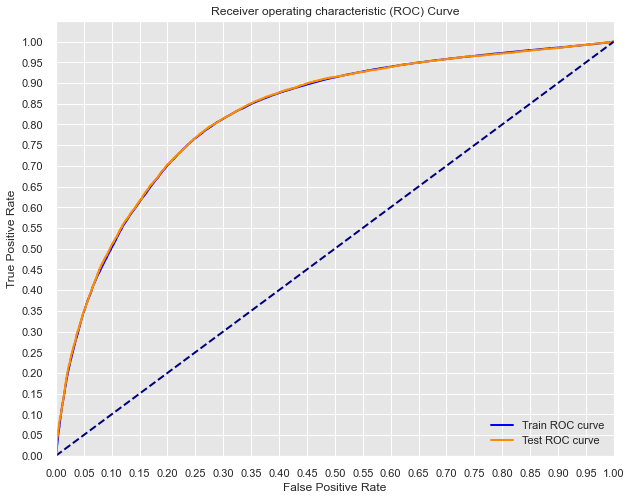

Train AUC: 0.8248832023412163
Test AUC: 0.8257318900637082


In [28]:
roc_auc(logregcv, X_train, X_test, y_train, y_test)

***
## LR Model 3: GridSearchCV

### Instantiate classifier

In [29]:
logreg = LogisticRegression()

### Create Parameter Grid 

In [30]:
log_param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

### Instantiate GridSearchCV and fit

In [31]:
gs_log = GridSearchCV(logreg, log_param_grid, cv=3, return_train_score=True,
                      n_jobs=-1)

In [32]:
gs_log.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             return_train_score=True)

### Best parameters

In [33]:
print("Best Parameter Combination Found During Grid Search:")
gs_log.best_params_

Best Parameter Combination Found During Grid Search:


{'C': 0.01, 'penalty': 'l2'}

### Predict

In [34]:
pred = gs_log.predict(X_test)

### Model Coefficients

In [35]:
#find_coeffs(gs_log, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.77      0.76      0.76     22069
     Popular       0.75      0.75      0.75     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664



----------------------------------------------------------
Training Accuracy Score: 75.75%
Testing Accuracy Score: 75.68%
Accuracy: 75.68%


----------------------------------------------------------


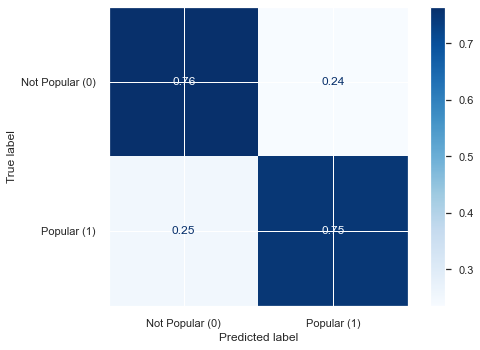

In [36]:
model_performance(gs_log, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

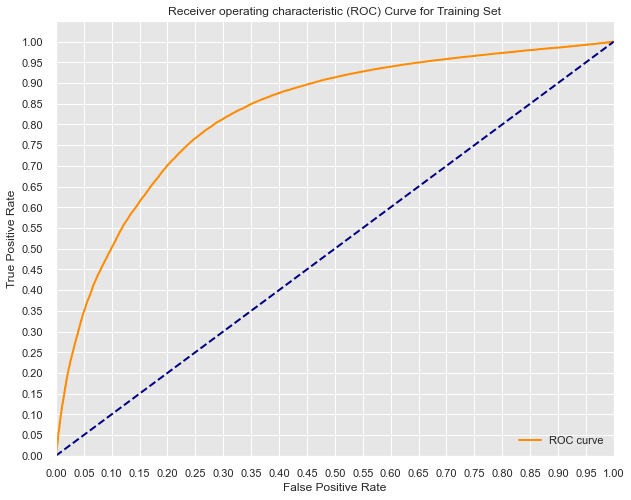

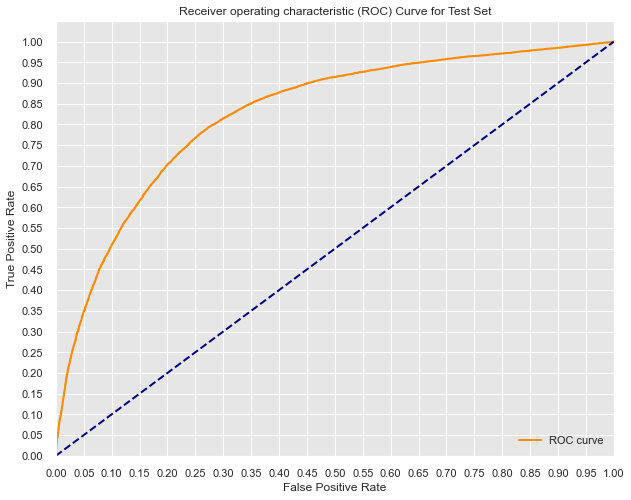

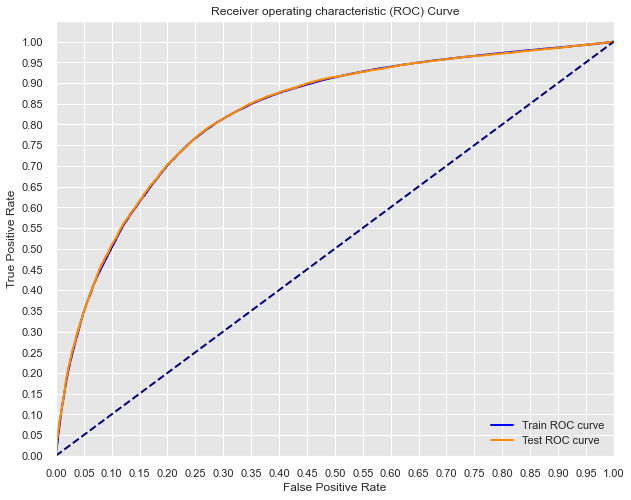

Train AUC: 0.8248878066523203
Test AUC: 0.825727714147679


In [37]:
roc_auc(gs_log, X_train, X_test, y_train, y_test)

***
# Decision Trees Models
***

## DT Model 1: Baseline DecisionTree Model

### Instantiate classifier and fit model

In [38]:
dtree_clf = DecisionTreeClassifier() 
dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

### Predict

In [39]:
pred = dtree_clf.predict(X_test)

### Summary Plot Mean absolute error of each feature

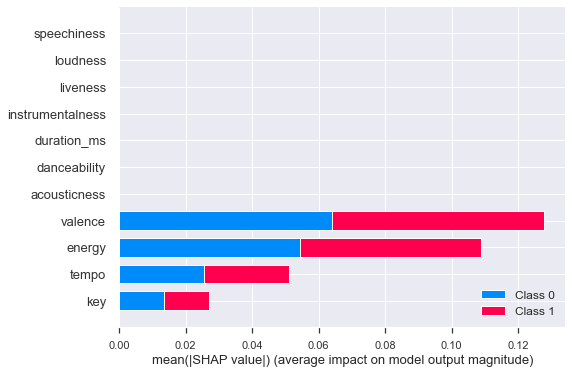

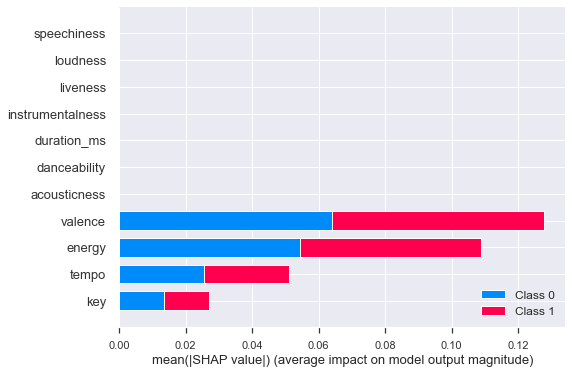

In [77]:
plot_shap_tree(dtree_clf, X_train, X)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.71      0.72      0.71     22069
     Popular       0.69      0.69      0.69     20595

    accuracy                           0.70     42664
   macro avg       0.70      0.70      0.70     42664
weighted avg       0.70      0.70      0.70     42664



----------------------------------------------------------
Training Accuracy Score: 99.72%
Testing Accuracy Score: 70.27%
Accuracy: 70.27%


----------------------------------------------------------


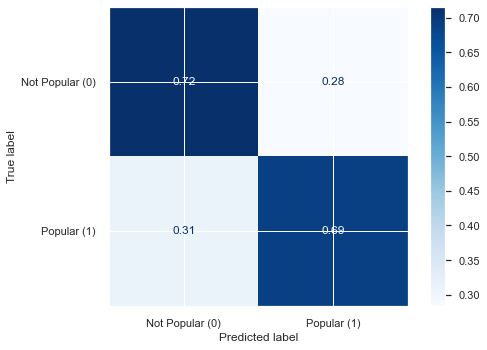

In [42]:
model_performance(dtree_clf, X_train, X_test, y_train, y_test, pred)

### Feature Importances

acousticness        0.284902
loudness            0.125380
duration_ms         0.087010
speechiness         0.084753
danceability        0.073324
valence             0.073112
liveness            0.065393
tempo               0.062158
instrumentalness    0.058381
energy              0.056622
key                 0.028965
dtype: float64

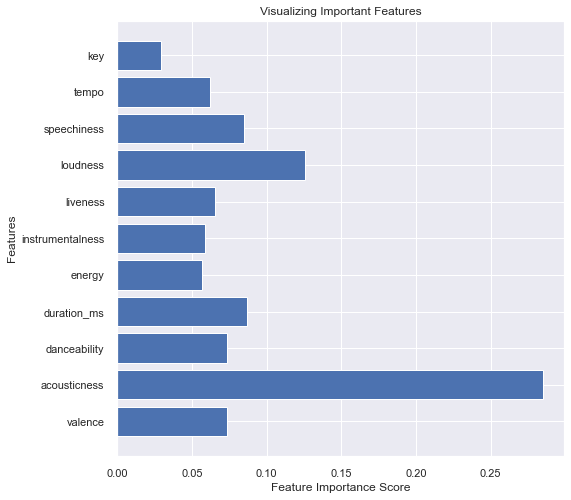

In [43]:
plot_feature_importances(dtree_clf, X_train, X)

### ROC Curve and AUC

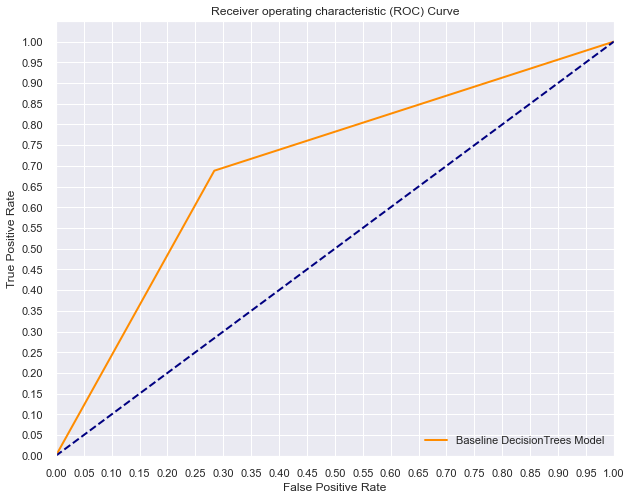

AUC: 0.7021763288023873


In [44]:
label = 'Baseline DecisionTrees Model'

roc_dt_rf(y_test, pred, label=label)

***
## DT Model 2: Bagged DecisionTree

### Instantiate classifier and fit

In [45]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier())
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier())

### Predict

In [46]:
pred = bagged_tree.predict(X_test)

### Summary Plot Mean absolute error of each feature

In [79]:
plot_shap_tree(bagged_tree, X_train, X)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._bagging.BaggingClassifier'>

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.75      0.81      0.78     22069
     Popular       0.77      0.71      0.74     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664



----------------------------------------------------------
Training Accuracy Score: 98.45%
Testing Accuracy Score: 76.0%
Accuracy: 76.0%


----------------------------------------------------------


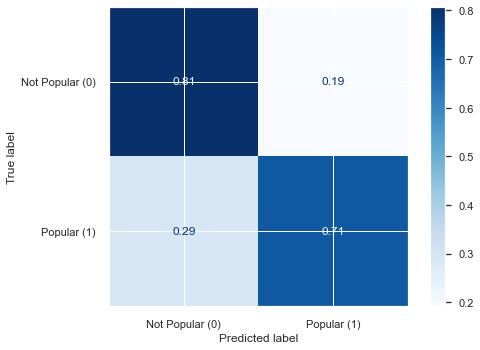

In [49]:
model_performance(bagged_tree, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

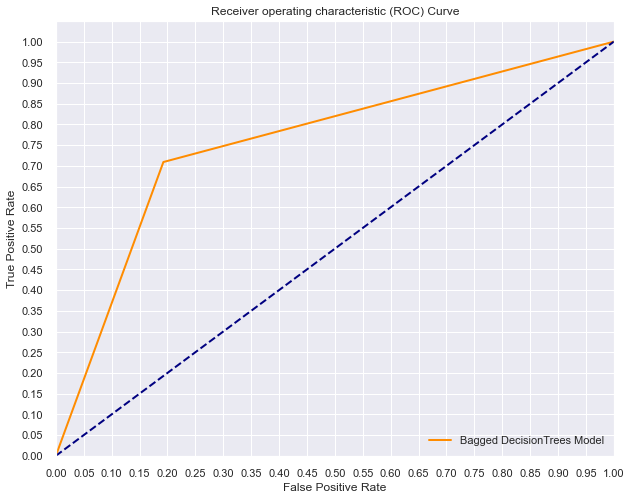

AUC: 0.7582696497888264


In [50]:
label = 'Bagged DecisionTrees Model'

roc_dt_rf(y_test, pred, label=label)

***
## DT Model 3: DecisionTree GridSearch 

### Instantiate classifier

In [51]:
dtree_model = DecisionTreeClassifier() 

### Create Parameter Grid

In [52]:
dt_param_grid = {
     'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 6]
}

### Instantiate GridSearchCV and fit

In [53]:
dt_grid_search = GridSearchCV(dtree_model, dt_param_grid, cv=3,
                              return_train_score=True, n_jobs=-1)

In [54]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [2, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

### Best parameters

In [55]:
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

### Predict

In [56]:
pred = dt_grid_search.predict(X_test)

### Model Coefficients

In [57]:
#find_coeffs(dt_grid_search, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.76      0.78      0.77     22069
     Popular       0.76      0.74      0.75     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664



----------------------------------------------------------
Training Accuracy Score: 78.34%
Testing Accuracy Score: 76.12%
Accuracy: 76.12%


----------------------------------------------------------


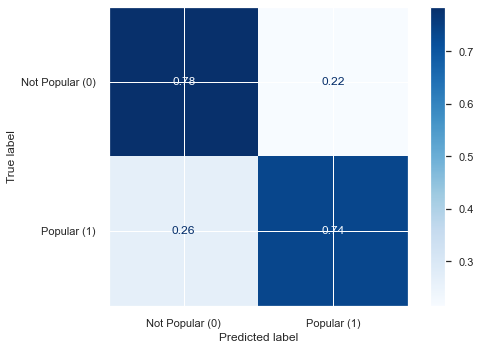

In [59]:
model_performance(dt_grid_search, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

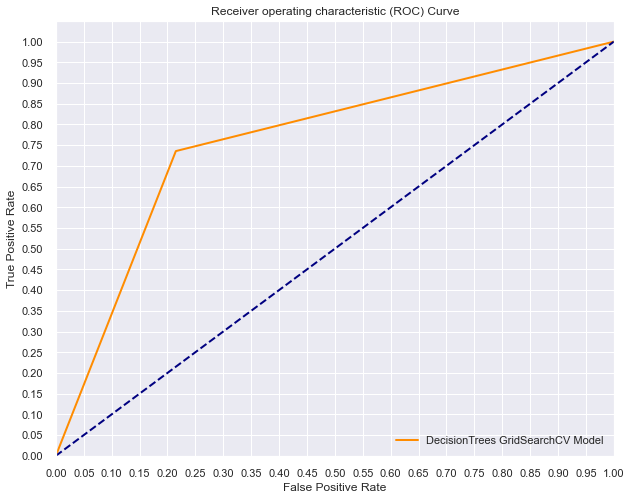

AUC: 0.7603072250904875


In [60]:
label = 'DecisionTrees GridSearchCV Model'

roc_dt_rf(y_test, pred, label=label)

***
# Random Forests Models
***

## RF Model 1: Baseline Model

### Instantiate classifier and fit

In [61]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

### Predict

In [62]:
pred = forest.predict(X_test)

### Summary Plot Mean absolute error of each feature

In [1]:
plot_shap_tree(forest, X_train, X)

NameError: name 'plot_shap_tree' is not defined

### Model Coefficients

In [64]:
#find_coeffs(forest, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.78      0.79      0.79     22069
     Popular       0.78      0.77      0.77     20595

    accuracy                           0.78     42664
   macro avg       0.78      0.78      0.78     42664
weighted avg       0.78      0.78      0.78     42664



----------------------------------------------------------
Training Accuracy Score: 99.72%
Testing Accuracy Score: 77.98%
Accuracy: 77.98%


----------------------------------------------------------


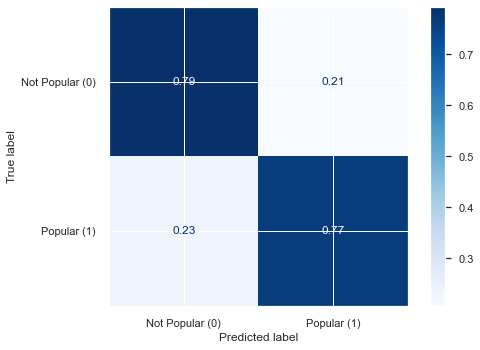

In [65]:
model_performance(forest, X_train, X_test, y_train, y_test, pred)

Notes:
* Model has accuracy of 85% 
* Issues predicting popular songs. Too many false negatives and false positives

### ROC Curve and AUC

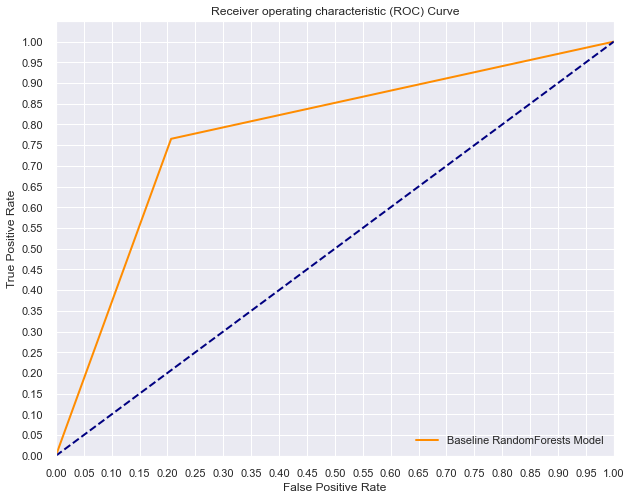

AUC: 0.7793533569827031


In [66]:
label = 'Baseline RandomForests Model'
roc_dt_rf(y_test, pred, label=label)

***
## RF Model 2: GridSearchCV Model

### Instantiate classifier

In [67]:
rforest_model = RandomForestClassifier()

### Create Parameter Grid

In [68]:
rf_param_grid = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

### Instantiate GridSearchCV and fit

In [69]:
rf_grid_search = GridSearchCV(rforest_model, rf_param_grid, cv=3,
                            return_train_score=True, n_jobs=-1)

In [70]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5], 'min_samples_leaf': [3, 6],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 100]},
             return_train_score=True)

### Best parameters

In [71]:
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

### Predict

In [72]:
pred = rf_grid_search.predict(X_test)

### Model Coefficients

In [73]:
#find_coeffs(rf_grid_search, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.79      0.79      0.79     22069
     Popular       0.77      0.77      0.77     20595

    accuracy                           0.78     42664
   macro avg       0.78      0.78      0.78     42664
weighted avg       0.78      0.78      0.78     42664



----------------------------------------------------------
Training Accuracy Score: 95.89%
Testing Accuracy Score: 78.15%
Accuracy: 78.15%


----------------------------------------------------------


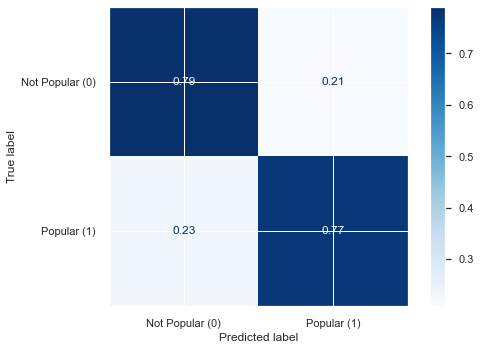

In [75]:
model_performance(rf_grid_search, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

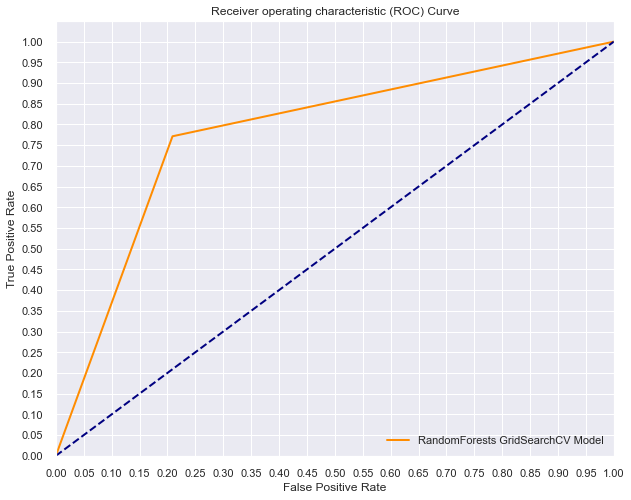

AUC: 0.7811662600813967


In [76]:
label = 'RandomForests GridSearchCV Model'

roc_dt_rf(y_test, pred, label=label)